In [27]:
STOCK_SIZE = 100

In [60]:
def read_instance(path):
    with open(path, 'r') as f:
        orders = [int(x) for x in f.readline().split()]
        return orders

nk - The number of the ordered small items by the length of l k .

N - The number of all small items.

li - The length of the i th ordered item.

M - The number of all large objects. - moze da ne bude dato u zadatku vec da se izracuna u initialize f-ji

Lj - The length of the j th large object.

wj - The trim loss appeared on j th large object.

Xij - A binary variable which is equal to one if the i th Item is cut from the j th large object and
zero otherwise.

wj = Lj − for i in range(N) for j in range(M)(li * xij) - calc trim loss 

0 <= wj <= Lj - logicno

0 < j < M - materijal koji imamo

0 < i < N - broj porucenih 

# Cplex

In [8]:
from docplex.mp.model import Model

In [9]:
orders = read_instance('test_instances/test_instance_11.csp')
initial_value, initial_stocks_used = calc_solution_value(orders)
print(initial_value, initial_stocks_used)

775902 317


In [10]:
model = Model(name='CSP')

In [11]:
num_stocks = len(orders)
num_orders = len(orders)

order_list = model.integer_var_list(num_orders, lb=orders, ub=orders, name='orders')

In [12]:
order_placement = model.binary_var_matrix(num_stocks, num_orders, name='order_placement')
stock_used = model.binary_var_list(num_stocks, name='stock_used')

In [13]:
for i in range(num_stocks):
    model.add_constraint(sum(order_placement[i,j] * order_list[j] for j in range(num_orders)) <= STOCK_SIZE * stock_used[i])
    
for j in range(num_orders):
    model.add_constraint(sum(order_placement[i,j] for i in range(num_stocks)) == 1)
    
model.minimize(sum(stock_used))

In [14]:
solution = model.solve()

In [16]:
print(solution.get_objective_value())

299.0


# Simulated annealing

In [15]:
import math
from matplotlib import pyplot as plt
import random
from copy import deepcopy

In [16]:
def initialize(orders: list[int], shuffle: bool = False) -> list[int]:
    solution = deepcopy(orders)
    if shuffle:
        random.shuffle(solution)
    return solution

In [72]:
def calc_solution_value(orders: list[int]) -> tuple[int, int]:
    
    leftovers = []
    num_stocks = 0
    current_stock_size = STOCK_SIZE
    
    for order in orders:
        if order <= current_stock_size:
            current_stock_size -= order
        else:
            leftover = current_stock_size
            leftovers.append(leftover)
            num_stocks += 1
            current_stock_size = STOCK_SIZE - order
    
    if current_stock_size != STOCK_SIZE:
        leftovers.append(current_stock_size)
        
    leftovers.sort(reverse = True)
        
    result = 0    
    for i, leftover in enumerate(leftovers):
        if leftover == 0:
            break
        result += (i+1) * leftover
        
    return result, num_stocks

In [18]:
def multiple_swaps(orders: list[int]):
    num_orders = len(orders)
    idxs = list(range(num_orders))
    random_length = random.randrange(1, num_orders)
    chosen = random.sample(idxs, k = random_length)
    for i in range(random_length):
        for j in range(chosen[i] + 1, num_orders):
            if orders[chosen[i]] != orders[j]:
                tmp = orders[chosen[i]]
                orders[chosen[i]] = orders[j]
                orders[j] = tmp
                break
                
def swap(orders: list[int]): 
    idx1 = random.randrange(len(orders))
    idx2 = random.randrange(len(orders))
    while orders[idx1] == orders[idx2]:
        idx2 = random.randrange(len(orders))
        
    tmp = orders[idx1]
    orders[idx1] = orders[idx2]
    orders[idx2] = tmp

In [19]:
def calc_temperature_1(current_temp: float, alpha: float) -> float:
    return current_temp / (1 + alpha * current_temp)

def calc_temperature_2(current_temp: float, alpha: float) -> float:
    return current_temp * alpha

def calc_alpha(initial_temp: float, min_temp: float) -> float:
    return (initial_temp - min_temp) / (num_iters * initial_temp * min_temp)

In [56]:
from typing import Callable

def simulated_annealing(orders: list[int],
                        initial_temp: float = 100,
                        min_temp: float = 10,
                        alpha: float = 0.9,
                        max_iters: int = 10000,
                        make_small_change: Callable[[list[int]], None] = swap,
                        calc_temperature: Callable[[float, float], float] = calc_temperature_1,
                        plot: bool = False,
                        max_accepted_solutions: int = 3
                        ) -> tuple[list[int], int, int]:
    
    num_orders = len(orders)
    solution = initialize(orders)
    temperature = initial_temp
    
    value, stocks_used = calc_solution_value(solution)
    best_solution = deepcopy(solution)
    best_value = value
    best_stocks_used = stocks_used

    PLT_VALUES = []
    PLT_STOCKS_USED = []
    ITERS = 0
    
    while temperature > min_temp and ITERS < max_iters:
        accepted_solutions = 0
        new_solution = deepcopy(solution)
        make_small_change(new_solution)
        new_value, new_stocks_used = calc_solution_value(new_solution)
        
        diff = new_value - value
        if diff <= 0:
            solution = deepcopy(new_solution)
            value = new_value
            stocks_used = new_stocks_used
            
            if new_value < best_value:
                best_value = new_value
                best_solution = deepcopy(new_solution)
                best_stocks_used = new_stocks_used
                
            accepted_solutions += 1    
            
        elif random.random() < (math.e)**((-diff) / temperature):
                value = new_value
                solution = deepcopy(new_solution)
                stocks_used = new_stocks_used
                accepted_solutions += 1
        
        if diff > 0 or accepted_solutions >= max_accepted_solutions:
            temperature = calc_temperature(temperature, alpha)
        
        PLT_VALUES.append(value)
        PLT_STOCKS_USED.append(stocks_used)
        ITERS += 1
            
    if plot:      
        plt.figure(figsize=(10, 3))
        plt.subplot(1, 2, 1)
        plt.plot(range(ITERS), PLT_VALUES, label='Value')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(range(ITERS), PLT_STOCKS_USED, label='Stocks used')
        plt.legend()
        plt.show()
    
    return best_solution, best_value, best_stocks_used

In [57]:
orders = [20, 30, 50, 10, 5, 5, 80, 35, 25, 40, 8, 12, 33, 27, 20, 90, 10, 90, 2, 3, 4, 1]
random.shuffle(orders)

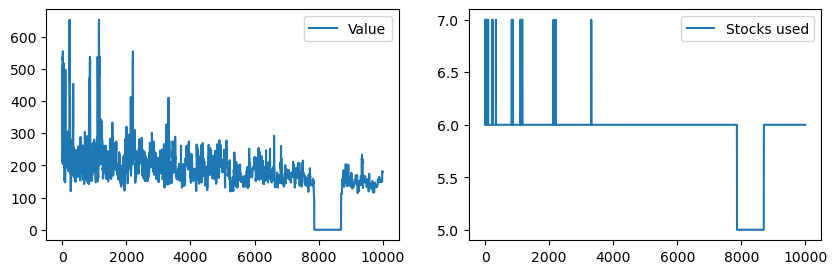

[20, 80, 2, 5, 90, 3, 8, 40, 25, 27, 30, 50, 20, 10, 90, 33, 5, 1, 12, 35, 10, 4] 0 5


In [58]:
initial_temp = 100
min_temp = 10
num_iters = 10000 # todo
a = calc_alpha(initial_temp, min_temp)
solution, value, stocks_used = simulated_annealing(orders, alpha=a, plot=True)
print(solution, value, stocks_used)

In [65]:
orders = read_instance('test_instances/test_instance_20.csp')
initial_value, initial_stocks_used = calc_solution_value(orders)
print(initial_value, initial_stocks_used)

4478851 751


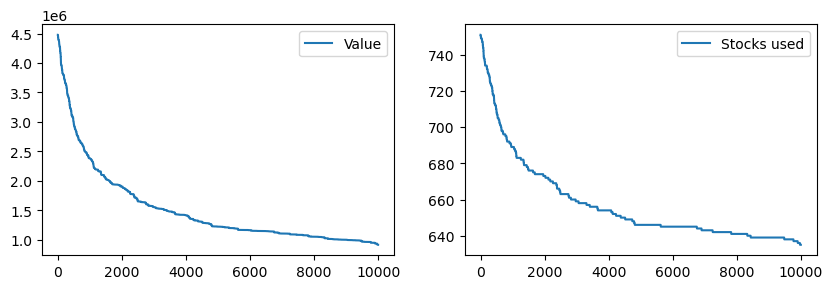

917027 635


In [62]:
#Staro

solution, value, stocks_used = simulated_annealing(orders, alpha=a, plot=True)
print(value, stocks_used)

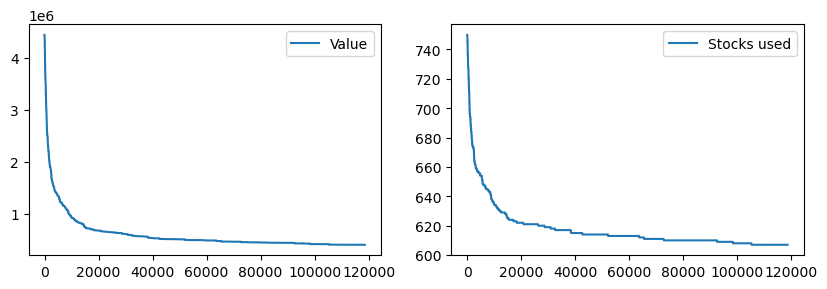

407144 607


In [68]:
solution, value, stocks_used = simulated_annealing(orders, alpha=a, plot=True, max_iters=1000000, min_temp=1)
print(value, stocks_used)

In [23]:
orders = read_instance('test_instances/test_instance_6.csp')
initial_value, initial_stocks_used = calc_solution_value(orders)
print(initial_value, initial_stocks_used)

137384 118


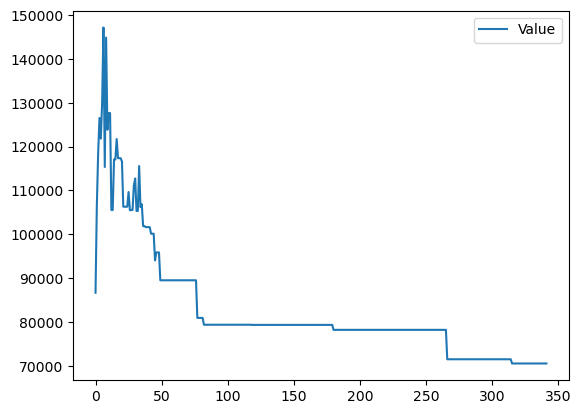

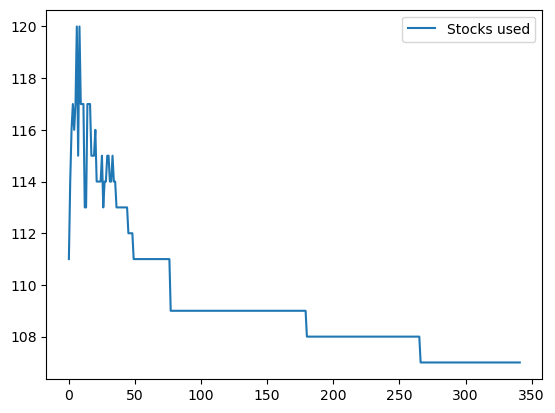

70518 107


In [24]:
solution, value, stocks_used = simulated_annealing(orders, T=40000, min_temperature=1e-3, a=0.95)
print(value, stocks_used)

# Genetic algorithm

In [21]:
POPULATION_SIZE = 100
NUM_ITERS = 10
ELITISM_SIZE = 20
MUTATION_PROB = 0.05
TOURNAMENT_SIZE = 5

class Individual:
    def __init__(self, orders):
        code = deepcopy(orders)
        random.shuffle(code)
        self.code = code
        self.fitness, self.num_stocks = calc_solution_value(orders)

In [22]:
def ga(orders):
    population = [Individual(orders) for _ in range(POPULATION_SIZE)]
    new_population = [Individual(orders) for _ in range(POPULATION_SIZE)]
    
    PLT_VALUES = []
    PLT_STOCKS_USED = []
    
    for _ in range(NUM_ITERS):
        population.sort(key=lambda x: x.fitness)
        new_population[:ELITISM_SIZE] = population[:ELITISM_SIZE]
        
        PLT_VALUES.append(population[0].fitness)
        PLT_STOCKS_USED.append(population[0].num_stocks)

        for i in range(ELITISM_SIZE, POPULATION_SIZE, 2):
            parent1 = selection(population, None)
            parent2 = selection(population, parent1)
            
            crossover(parent1, parent2, new_population[i], new_population[i+1])
            
            mutation(new_population[i], MUTATION_PROB)
            mutation(new_population[i+1], MUTATION_PROB)
            
            new_population[i].fitness, new_population[i].num_stocks = calc_solution_value(new_population[i].code)
            new_population[i+1].fitness, new_population[i+1].num_stocks = calc_solution_value(new_population[i+1].code)
        
        population[:] = new_population[:]
    
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.plot(range(NUM_ITERS), PLT_VALUES, label='Value')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(NUM_ITERS), PLT_STOCKS_USED, label='Stocks used')
    plt.legend()
    plt.show()
    
    best_individual = min(population, key=lambda x: x.fitness)
    return best_individual.code, best_individual.fitness, best_individual.num_stocks

In [23]:
def selection(population, forbidden):
    allowed = list(set(population).difference({forbidden}))
    chosen = random.sample(allowed, TOURNAMENT_SIZE)
    return min(chosen, key=lambda x: x.fitness)

In [24]:
def crossover(parent1, parent2, child1, child2):
    pos = random.randrange(1, len(parent1.code))
    
    child1.code[:pos] = parent1.code[:pos]
    child1.code[pos:] = parent2.code[pos:]
    
    child2.code[:pos] = parent2.code[:pos]
    child2.code[pos:] = parent1.code[pos:]

In [25]:
def mutation(instance, prob):
    if random.random() < prob:
        pos1 = random.randrange(len(instance.code))
        pos2 = random.randrange(len(instance.code))
        
        tmp = instance.code[pos1]
        instance.code[pos1] = instance.code[pos2]
        instance.code[pos2] = tmp

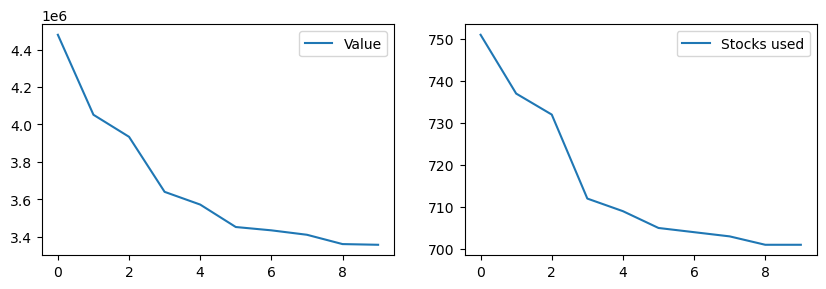

3340563 700


In [43]:
orders = read_instance('test_instances/test_instance_20.csp')
solution, value, num_stocks = ga(orders)
print(value, num_stocks)

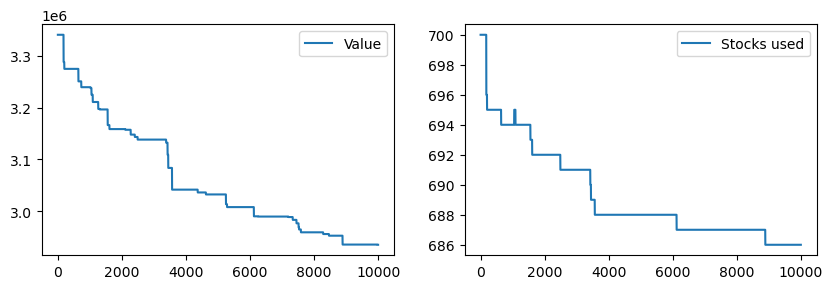

2935304 686


In [44]:
solution, value, num_stocks = simulated_annealing(solution, initial_temp, min_temp, a)
print(value, num_stocks)

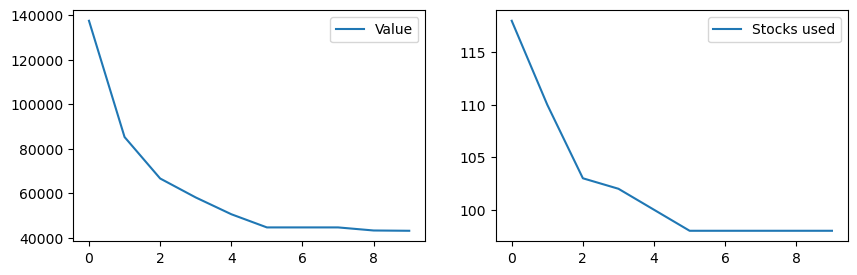

42895 98


In [68]:
orders = read_instance('test_instances/test_instance_6.csp')
solution, value, num_stocks = ga(orders)
print(value, num_stocks)

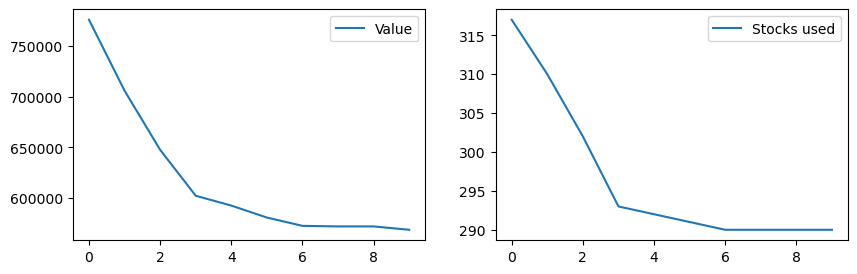

564547 289


In [70]:
orders = read_instance('test_instances/test_instance_11.csp')
solution, value, num_stocks = ga(orders)
print(value, num_stocks)